In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 300)

In [2]:
lst = [2020, 2021, 2022, 2023, 2024]
unit = 11

In [3]:
dfs = []
for i in range(len(lst) - 1):
  dfs.append(pd.read_excel(f'csv/{lst[i]}-{lst[i+1]}_NBA_Box_Score_Team-Stats.xlsx'))

In [4]:
dfs[-1] = dfs[-1].rename({'VENUE\n(R/H/N)' : 'VENUE'}, axis=1)
df = pd.concat(dfs)

In [5]:
nba_teams = {
    "Brooklyn": 1,
    "LA Lakers": 2,
    "Boston": 3,
    "Phoenix": 4,
    "Cleveland": 5,
    "Indiana": 6,
    "Orlando": 7,
    "Philadelphia": 8,
    "Toronto": 9,
    "Chicago": 10,
    "Memphis": 11,
    "Minnesota": 12,
    "Denver": 13,
    "Portland": 14,
    "Miami": 15,
    "Milwaukee": 16,
    "Charlotte": 17,
    "Detroit": 18,
    "Washington": 19,
    "New York": 20,
    "San Antonio": 21,
    "Utah": 22,
    "Sacramento": 23,
    "LA Clippers": 24,
    "New Orleans": 25,
    "Atlanta": 26,
    "Oklahoma City": 27,
    "Dallas": 28,
    "Houston": 29,
    "Golden State": 30
}

In [7]:
df['type'] = df['BIGDATABALL\nDATASET'].apply(lambda x: x.split()[2])

In [8]:
reg = df[df['type'] == 'Regular']

In [9]:
reg['STARTING LINEUPS']

0           Andrew Wiggins
1               Joe Harris
2            Kawhi Leonard
3             LeBron James
4          Khris Middleton
               ...        
2457        Brandon Ingram
2458         Grayson Allen
2459       Jaden McDaniels
2460    Michael Porter Jr.
2461            GG Jackson
Name: STARTING LINEUPS, Length: 9408, dtype: object

In [11]:
game_metadata = ['BIGDATABALL\nDATASET', 'GAME-ID', 'DATE', 'TEAM', 'VENUE']
game_stats = ['F', 'MIN', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'OR', 'DR', 'TOT', 'A', 'PF', 'ST', 'TO', 'BL', 'PTS', 'POSS', 'PACE', 'OEFF', 'DEFF']
game_stats_avg = [x + '_mean' for x in game_stats]
starters = ['STARTING LINEUPS', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41']

In [12]:
data = reg[game_metadata + game_stats + starters]

In [13]:
aggs = data.set_index('GAME-ID').groupby(['BIGDATABALL\nDATASET', 'TEAM'])[game_stats].expanding().mean().rename(lambda x: x+ "_mean", axis=1).groupby(['BIGDATABALL\nDATASET', 'TEAM']).shift(1).reset_index()

In [14]:
final = pd.merge(data, aggs, on = ['BIGDATABALL\nDATASET', 'TEAM', 'GAME-ID'])

In [15]:
totals = data.groupby('GAME-ID').sum()['PTS'].reset_index().rename({'PTS':'y'}, axis=1)

In [16]:
final = pd.merge(final, totals, on = 'GAME-ID')

In [17]:
x_vars = game_metadata + game_stats_avg

In [19]:
games = pd.merge(final[final.VENUE == 'H'][x_vars + ['y']], final[final.VENUE == 'R'][x_vars + ['y']], on=['BIGDATABALL\nDATASET', 'DATE', 'GAME-ID', 'y'])

In [20]:
games = games.rename({'BIGDATABALL\nDATASET': 'Season'}, axis=1)

In [21]:
final_x_vars = list(set(games.columns.to_list()) - set(['DATE', 'y']))

In [22]:
import lightgbm as lgb

In [23]:
games['Season'] = games['Season'].apply(lambda x: int(x.split()[1].split('-')[0]))

In [24]:
games['TEAM_x'] = games['TEAM_x'].apply(lambda x: nba_teams[x])
games['TEAM_y'] = games['TEAM_y'].apply(lambda x: nba_teams[x])

In [25]:
games['VENUE_x'] = games['TEAM_x']
games['VENUE_y'] = games['TEAM_x']

In [26]:
games['DATE'] = games.DATE.apply(lambda x: int(int(x.split('/')[2]) * 1e4 + int(x.split('/')[0]) * 1e2 + int(x.split('/')[1])))

In [28]:
train = games[games['Season'] != 2023]

In [29]:
test = games[games['Season'] == 2023]

In [30]:
train_data = lgb.Dataset(train[final_x_vars], label = train['y'])

In [31]:
test_data = lgb.Dataset(test[final_x_vars], label = test['y'])

In [106]:
params = {
    "objective": "regression",
    "boosting_type": "rf",
    "num_leaves": 15,
    "force_row_wise": True,
    "learning_rate": 0.1,
    "bagging_fraction": 0.9,
    "feature_fraction": 0.5
}
# Train the LightGBM model
num_round = 100
bst = lgb.train(params, train_data, num_round)

[LightGBM] [Info] Total Bins 11072
[LightGBM] [Info] Number of data points in the train set: 3540, number of used features: 48
[LightGBM] [Info] Start training from score 224.960169


In [107]:
lines = pd.merge(test, reg[['GAME-ID', 'OPENING TOTAL']].drop_duplicates(), on = 'GAME-ID')

In [108]:
lines['pred'] = pd.Series(bst.predict(test[final_x_vars]))

In [109]:
preds = lines[['DATE', 'y', 'OPENING TOTAL', 'pred']]

In [110]:
preds['OU'] = np.sign(preds.pred - preds['OPENING TOTAL'])

/var/folders/kd/kpwj_zw52bjbbtxgq2psc1080000gn/T/ipykernel_52259/1577859951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['OU'] = np.sign(preds.pred - preds['OPENING TOTAL'])


In [111]:
preds['Outcome'] = np.sign(preds.y - preds['OPENING TOTAL'])

/var/folders/kd/kpwj_zw52bjbbtxgq2psc1080000gn/T/ipykernel_52259/2002246133.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['Outcome'] = np.sign(preds.y - preds['OPENING TOTAL'])


In [112]:
(preds.OU == preds.Outcome).value_counts()

True     605
False    557
Name: count, dtype: int64

In [113]:
(preds.OU == preds.Outcome).value_counts().loc[True] / preds.shape[0]

0.5206540447504303

In [114]:
(preds.OU == preds.Outcome).value_counts().loc[True] / preds.shape[0] - 11/21

-0.0031554790590935244

In [115]:
preds.corr()

,DATE,y,OPENING TOTAL,pred,OU,Outcome
DATE,1.000000,-0.102662,-0.074140,0.181065,0.146857,-0.087152
y,-0.102662,1.000000,0.444879,0.314991,-0.332679,0.690779
OPENING TOTAL,-0.074140,0.444879,1.000000,0.615085,-0.729708,-0.057761
pred,0.181065,0.314991,0.615085,1.000000,-0.186069,-0.014569
OU,0.146857,-0.332679,-0.729708,-0.186069,1.000000,0.042964
Outcome,-0.087152,0.690779,-0.057761,-0.014569,0.042964,1.000000


In [116]:
preds['DATE'] = pd.to_datetime(preds['DATE'].apply(str), format = "%Y%m%d") 

/var/folders/kd/kpwj_zw52bjbbtxgq2psc1080000gn/T/ipykernel_52259/1270250952.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['DATE'] = pd.to_datetime(preds['DATE'].apply(str), format = "%Y%m%d")


In [117]:
preds['pnl'] = np.where(preds.OU == preds.Outcome, unit * 10/11, -unit)

/var/folders/kd/kpwj_zw52bjbbtxgq2psc1080000gn/T/ipykernel_52259/135542864.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['pnl'] = np.where(preds.OU == preds.Outcome, unit * 10/11, -unit)


In [118]:
preds['correct'] = preds.OU * preds.Outcome

/var/folders/kd/kpwj_zw52bjbbtxgq2psc1080000gn/T/ipykernel_52259/2614251419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['correct'] = preds.OU * preds.Outcome


<Axes: xlabel='DATE'>

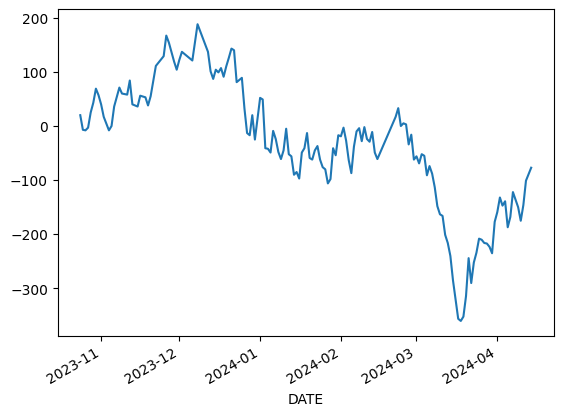

In [119]:
preds.groupby('DATE').pnl.sum().cumsum().plot()